# Data Science Research Project A - Free Space Optical Communication Channel Model
## 1. Data Loading and preprocesing

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Set random seed
seed = 22
np.random.seed(seed)
random.seed(seed)

# Set display options to avoid line wrapping
pd.set_option('display.expand_frame_repr', False) 

file_path = 'RFLFSODataFull.csv'  
data = pd.read_csv(file_path)

print("data info:")
print(data.info())
print("\ndata head:")
print(data.head())
print("\ndata distribution:")
print(data.describe())

X = data.drop(columns=['RFL_Att', 'FSO_Att'])
y = data['FSO_Att']

# Split the dataset by weather condition levels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22, stratify=data['SYNOPCode'])

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int6


 SYNOPCode count:
0    56964
6    25018
5     6605
8     1716
4      466
7      419
3      191
Name: SYNOPCode, dtype: int64


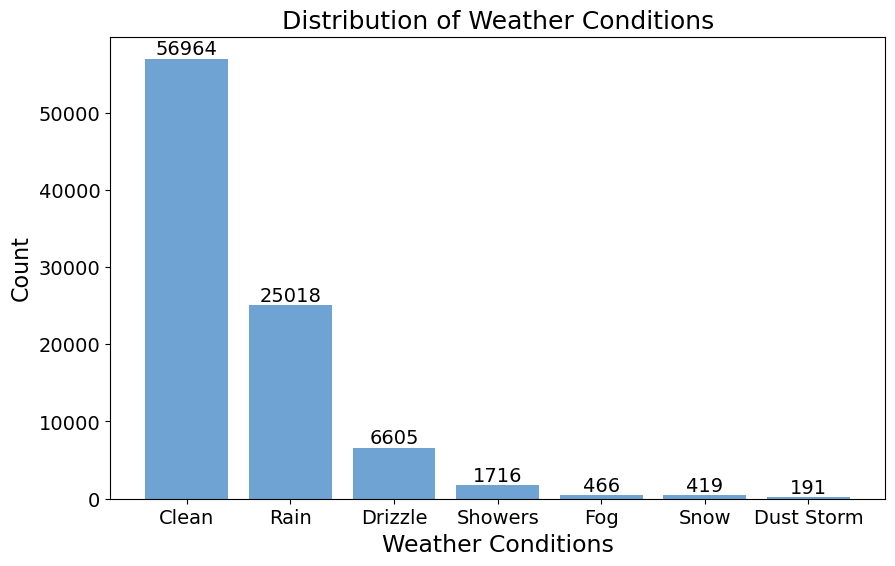

In [2]:
# Print SYNOPCode count
print("\n SYNOPCode count:")
synop_counts = data['SYNOPCode'].value_counts()
print(synop_counts)

# Mapping from SYNOPCode to weather labels
weather_labels = {
    0: 'Clean',
    6: 'Rain',
    5: 'Drizzle',
    8: 'Showers',
    4: 'Fog',
    7: 'Snow',
    3: 'Dust Storm'
}

# Reindex and map weather labels
synop_counts = synop_counts.rename(index=weather_labels)

# Data visualisation
plt.figure(figsize=(10, 6))
bars = plt.bar(synop_counts.index, synop_counts.values, color='#6FA3D3')
plt.title('Distribution of Weather Conditions', fontsize=18)
plt.xlabel('Weather Conditions', fontsize=17)
plt.ylabel('Count', fontsize=16)

# Display count value on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=14)

# Set axis tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## 2. Method 1. Generic Random Forest model
### 2.1 Feature selection

In [3]:
def feature_selection_generic(X_train, y_train):
    print("\nProcessing Generic Model")
    
    # One-hot encode the SYNOPCode feature
    X_train = pd.get_dummies(X_train, columns=['SYNOPCode'], drop_first=True)

    # Initialize result lists
    results = []
    removed_features = []
    ordered_features = []  # List to store the remaining features
    last_removed_feature = None  # To store the last removed feature

    # Feature selection process
    iteration = 1  # Initialize iteration counter
    while X_train.shape[1] > 0:
        # Define the random forest model and use OOB score
        rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=22)
        rf.fit(X_train, y_train)

        # Get feature importances
        importances = rf.feature_importances_
        least_important_feature_index = np.argmin(importances)

        # Calculate OOB RMSE and R² for the current model
        oob_pred = rf.oob_prediction_
        rmse = mean_squared_error(y_train, oob_pred, squared=False)
        r2 = r2_score(y_train, oob_pred)

        # Store results
        results.append((rmse, r2))
        least_important_feature = X_train.columns[least_important_feature_index]
        removed_features.append(least_important_feature)

        # Print the current model's performance with 4 decimal places
        print(f"Iteration {iteration}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

        # Print the number of remaining features based on the iteration
        if iteration == 1:
            print(f"Remaining features: {X_train.shape[1]}")  # Display total features for the first iteration
        else:
            print(f"Removed feature: {last_removed_feature}. Remaining features: {X_train.shape[1]}")  # Display removed feature and remaining features for subsequent iterations
            
        last_removed_feature = least_important_feature  # Store the last removed feature

        # Drop the least important feature
        X_train = X_train.drop(columns=[least_important_feature])

        # Add to ordered_features list
        ordered_features.append(least_important_feature)

        iteration += 1  # Increment iteration counter

    # Add the last remaining feature
    if X_train.shape[1] > 0:
        ordered_features.append(X_train.columns[0])  # Assuming only one feature remains at this point

    # Extract RMSE and R² values
    rmse_values = [result[0] for result in results]
    r2_values = [result[1] for result in results]

    # Plot line charts
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RMSE line chart
    ax1.set_xlabel('Removed Features', fontsize=14) 
    ax1.set_ylabel('RMSE(dB)', color='tab:red', fontsize=14)  
    ax1.plot(range(len(rmse_values)), rmse_values, color='tab:red', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create second y-axis to plot R² line chart
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:blue', fontsize=14) 
    ax2.plot(range(len(r2_values)), r2_values, color='tab:blue', marker='o', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(rmse_values)))
    ax1.set_xticklabels(ordered_features, rotation=45, ha='right', fontsize=12) 
    # Add title and legend
    plt.title('Generic Model Performance for FSO Attenuation', fontsize=16) 
    fig.tight_layout() 
    plt.show()

    # Return the ordered_features list
    return ordered_features


Processing Generic Model
Iteration 1: RMSE = 0.8826, R² = 0.9490
Remaining features: 30
Iteration 2: RMSE = 0.8836, R² = 0.9488
Removed feature: SYNOPCode_4. Remaining features: 29
Iteration 3: RMSE = 0.8834, R² = 0.9489
Removed feature: SYNOPCode_8. Remaining features: 28
Iteration 4: RMSE = 0.8800, R² = 0.9492
Removed feature: SYNOPCode_7. Remaining features: 27
Iteration 5: RMSE = 0.8823, R² = 0.9490
Removed feature: Frequency. Remaining features: 26
Iteration 6: RMSE = 0.8831, R² = 0.9489
Removed feature: SYNOPCode_6. Remaining features: 25
Iteration 7: RMSE = 0.8812, R² = 0.9491
Removed feature: SYNOPCode_5. Remaining features: 24
Iteration 8: RMSE = 0.8831, R² = 0.9489
Removed feature: RainIntensityMax. Remaining features: 23
Iteration 9: RMSE = 0.8800, R² = 0.9492
Removed feature: RainIntensityMin. Remaining features: 22
Iteration 10: RMSE = 0.8703, R² = 0.9504
Removed feature: WindDirection. Remaining features: 21
Iteration 11: RMSE = 0.8693, R² = 0.9505
Removed feature: RainI

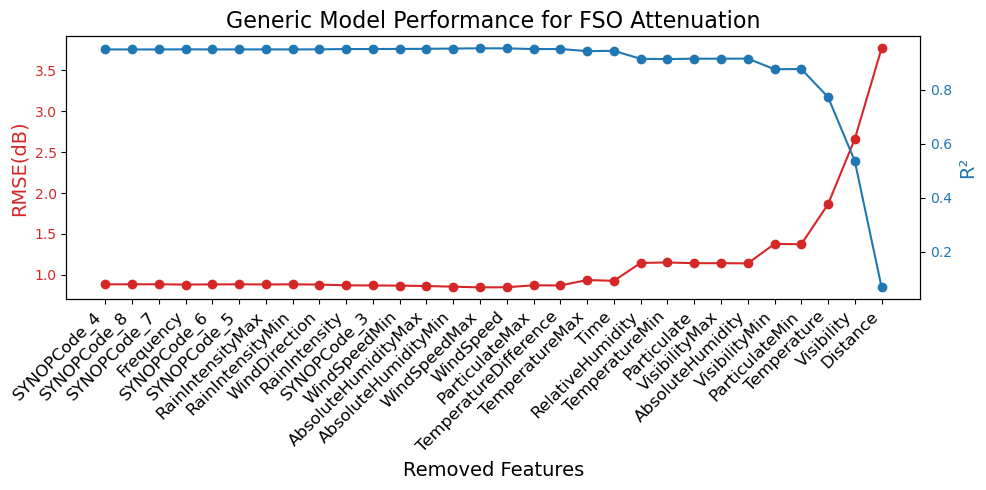

In [4]:
generic_ordered_feature = feature_selection_generic(X_train, y_train)

In [5]:
generic_selected_features = generic_ordered_feature[-13:] 
print(generic_selected_features)

['TemperatureDifference', 'TemperatureMax', 'Time', 'RelativeHumidity', 'TemperatureMin', 'Particulate', 'VisibilityMax', 'AbsoluteHumidity', 'VisibilityMin', 'ParticulateMin', 'Temperature', 'Visibility', 'Distance']


### 2.2 Hyperparameter optimisation

In [6]:
def tune_hyperparameters(X_train, y_train, selected_features):
    
    # Train using the passed selected features
    X_train_selected = X_train[selected_features]
    
    # Define the random forest model
    rf = RandomForestRegressor(oob_score=True, random_state=22)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 10, 20]
    }
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Get the best hyperparameter combination
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

In [7]:
# Use the 13 most important features for hyperparameter tuning
best_params = tune_hyperparameters(X_train, y_train, generic_selected_features)

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'n_estimators': 200}


### 2.3 Train and evalute the generic RF model with the best hyperparameter values

In [8]:
def train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, selected_features, best_params):
    # Train using the passed selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Define the model using the best hyperparameter combination
    generic_RF_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        oob_score=True,
        random_state=22
    )

    # Train the model on the training set
    generic_RF_model.fit(X_train_selected, y_train)

    # Predict on the training set
    y_train_pred = generic_RF_model.predict(X_train_selected)

    # Calculate RMSE and R² for the training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    # Predict on the test set
    y_test_pred = generic_RF_model.predict(X_test_selected)
    
    # Calculate RMSE and R² for the overall test set
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Print results for training and test sets
    print(f"Training RMSE of generic RF model: {train_rmse:.4f}")
    print(f"Training R² of generic RF model: {train_r2:.4f}")
    print(f"Test RMSE of generic RF model: {rmse_test:.4f}")
    print(f"Test R² of generic RF model: {r2_test:.4f}")
    
    # Store predicted and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    # Iterate through X_test
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred[X_test.index.get_loc(index)])  # Get the corresponding predicted value
            actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])  # Get the corresponding actual value

    # Calculate RMSE and R² for each weather condition
    gene_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            gene_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f'Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return rmse_test, r2_test, gene_condition_results

In [9]:
# Train the generic model with the best parameters
rmse_test, r2_test, gene_condition_results = train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, generic_selected_features, best_params)

Training RMSE of generic RF model: 0.3089
Training R² of generic RF model: 0.9937
Test RMSE of generic RF model: 0.8051
Test R² of generic RF model: 0.9573
Weather condition Clear: RMSE = 0.8054, R² = 0.9468
Weather condition Dust Storm: RMSE = 1.4144, R² = 0.9698
Weather condition Fog: RMSE = 0.7226, R² = 0.9733
Weather condition Drizzle: RMSE = 0.7692, R² = 0.9521
Weather condition Rain: RMSE = 0.7904, R² = 0.9663
Weather condition Snow: RMSE = 0.9415, R² = 0.9662
Weather condition Showers: RMSE = 1.0095, R² = 0.9428


From the hyperpararmeter tuning in generic model, we find the best hyperparameters are: {'max_depth': None, 'n_estimators': 200}. So we will use it as the model structure.

## 3. Method 2. Specific random forest models
### 3.1 Feature selection for each weather condition model

In [10]:
def feature_selection_for_weather(X_train, y_train, synop_code, condition):
    print(f"\nProcessing SYNOP Code: {synop_code} ({condition})")

    # Initialize result lists
    results = []
    removed_features = []
    ordered_features = []  # List to store retained features
    last_removed_feature = None  # To store the least important feature from the previous round

    # Feature selection process
    iteration = 1  # Initialize iteration counter
    while X_train.shape[1] > 0:
        # Define the Random Forest model using OOB score
        rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=22)
        rf.fit(X_train, y_train)

        # Get feature importance
        importances = rf.feature_importances_
        least_important_feature_index = np.argmin(importances)

        # Calculate OOB RMSE and R² for the current model
        oob_pred = rf.oob_prediction_  
        rmse = mean_squared_error(y_train, oob_pred, squared=False)
        r2 = r2_score(y_train, oob_pred)

        # Store results
        results.append((rmse, r2))
        least_important_feature = X_train.columns[least_important_feature_index]
        removed_features.append(least_important_feature)

        # Print current model performance, retaining five decimal places
        print(f"Iteration {iteration}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

        # Print feature count based on iteration number
        if iteration == 1:
            print(f"Remaining features: {X_train.shape[1]}")  # Show total feature count in the first round
        else:
            print(f"Removed feature: {last_removed_feature}. Remaining features: {X_train.shape[1]}")  # Show removed feature and remaining features in subsequent rounds
            
        last_removed_feature = least_important_feature  # Store least important feature from the previous round

        # Remove the least important feature
        X_train = X_train.drop(columns=[least_important_feature])

        # Add to ordered_features list
        ordered_features.append(least_important_feature)

        iteration += 1 

    # Add the last remaining feature
    if X_train.shape[1] > 0:
        ordered_features.append(X_train.columns[0])

    # Extract RMSE and R² values
    rmse_values = [result[0] for result in results]
    r2_values = [result[1] for result in results]

    # Plot the line chart
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RMSE line chart
    ax1.set_xlabel('Removed Features', fontsize=14) 
    ax1.set_ylabel('RMSE(dB)', color='tab:red', fontsize=14)  
    ax1.plot(range(len(rmse_values)), rmse_values, color='tab:red', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis to plot R² line chart
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:blue', fontsize=14)
    ax2.plot(range(len(r2_values)), r2_values, color='tab:blue', marker='o', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(rmse_values)))
    ax1.set_xticklabels(ordered_features, rotation=45, ha='right', fontsize=12) 
    # Add title and legend
    plt.title(f'{condition} Model Performance for FSO Attenuation', fontsize=16)
    fig.tight_layout() 
    plt.show()

    # Return ordered_features list
    return ordered_features

In [11]:
# Split the training set into different weather types based on 'SYNOPCode'
# Clear
X_train_clear = X_train[X_train['SYNOPCode'] == 0]
y_train_clear = y_train[X_train['SYNOPCode'] == 0]

# Dust Storm
X_train_dust_storm = X_train[X_train['SYNOPCode'] == 3]
y_train_dust_storm = y_train[X_train['SYNOPCode'] == 3]

# Fog
X_train_fog = X_train[X_train['SYNOPCode'] == 4]
y_train_fog = y_train[X_train['SYNOPCode'] == 4]

# Drizzle
X_train_drizzle = X_train[X_train['SYNOPCode'] == 5]
y_train_drizzle = y_train[X_train['SYNOPCode'] == 5]

# Rain
X_train_rain = X_train[X_train['SYNOPCode'] == 6]
y_train_rain = y_train[X_train['SYNOPCode'] == 6]

# Snow
X_train_snow = X_train[X_train['SYNOPCode'] == 7]
y_train_snow = y_train[X_train['SYNOPCode'] == 7]

# Showers
X_train_showers = X_train[X_train['SYNOPCode'] == 8]
y_train_showers = y_train[X_train['SYNOPCode'] == 8]


Processing SYNOP Code: 0 (Clear)
Iteration 1: RMSE = 0.8934, R² = 0.9360
Remaining features: 24
Iteration 2: RMSE = 0.8932, R² = 0.9361
Removed feature: RainIntensity. Remaining features: 23
Iteration 3: RMSE = 0.8926, R² = 0.9362
Removed feature: RainIntensityMin. Remaining features: 22
Iteration 4: RMSE = 0.8937, R² = 0.9360
Removed feature: RainIntensityMax. Remaining features: 21
Iteration 5: RMSE = 0.8904, R² = 0.9365
Removed feature: Frequency. Remaining features: 20
Iteration 6: RMSE = 0.8939, R² = 0.9360
Removed feature: ParticulateMax. Remaining features: 19
Iteration 7: RMSE = 0.8815, R² = 0.9377
Removed feature: WindDirection. Remaining features: 18
Iteration 8: RMSE = 0.8784, R² = 0.9382
Removed feature: ParticulateMin. Remaining features: 17
Iteration 9: RMSE = 0.8804, R² = 0.9379
Removed feature: WindSpeedMin. Remaining features: 16
Iteration 10: RMSE = 0.8733, R² = 0.9389
Removed feature: AbsoluteHumidityMin. Remaining features: 15
Iteration 11: RMSE = 0.9145, R² = 0.93

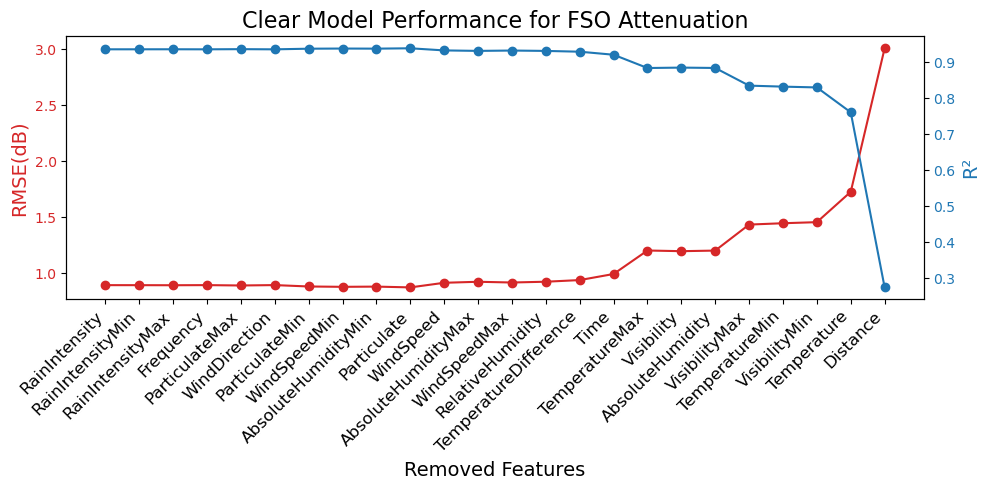

In [12]:
ordered_features_clear = feature_selection_for_weather(X_train_clear.drop(columns=['SYNOPCode']), y_train_clear, 0, 'Clear')

In [13]:
# Extract the last 10 features and train the model
clear_features = ordered_features_clear[-10:]
print(clear_features)

['TemperatureDifference', 'Time', 'TemperatureMax', 'Visibility', 'AbsoluteHumidity', 'VisibilityMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'Distance']



Processing SYNOP Code: 3 (Dust Storm)
Iteration 1: RMSE = 2.5057, R² = 0.9061
Remaining features: 24
Iteration 2: RMSE = 2.5978, R² = 0.8990
Removed feature: Particulate. Remaining features: 23
Iteration 3: RMSE = 2.5579, R² = 0.9021
Removed feature: ParticulateMax. Remaining features: 22
Iteration 4: RMSE = 2.5426, R² = 0.9033
Removed feature: ParticulateMin. Remaining features: 21
Iteration 5: RMSE = 2.6702, R² = 0.8933
Removed feature: RainIntensity. Remaining features: 20
Iteration 6: RMSE = 2.5293, R² = 0.9043
Removed feature: RainIntensityMax. Remaining features: 19
Iteration 7: RMSE = 2.6209, R² = 0.8972
Removed feature: RainIntensityMin. Remaining features: 18
Iteration 8: RMSE = 2.5677, R² = 0.9014
Removed feature: Frequency. Remaining features: 17
Iteration 9: RMSE = 2.5124, R² = 0.9056
Removed feature: WindDirection. Remaining features: 16
Iteration 10: RMSE = 2.5313, R² = 0.9041
Removed feature: WindSpeedMin. Remaining features: 15
Iteration 11: RMSE = 2.4834, R² = 0.9077


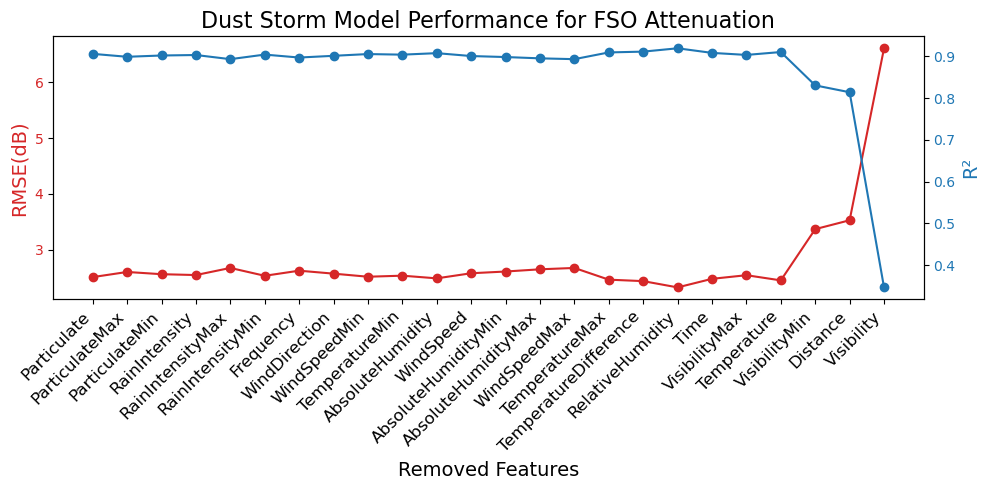

In [14]:
# Dust Storm
ordered_features_dust_storm = feature_selection_for_weather(X_train_dust_storm.drop(columns=['SYNOPCode']), y_train_dust_storm, 3, 'Dust Storm')

In [15]:
dust_storm_features = ordered_features_dust_storm[-7:]
print(dust_storm_features)

['RelativeHumidity', 'Time', 'VisibilityMax', 'Temperature', 'VisibilityMin', 'Distance', 'Visibility']



Processing SYNOP Code: 4 (Fog)
Iteration 1: RMSE = 0.7793, R² = 0.9559
Remaining features: 24
Iteration 2: RMSE = 0.7858, R² = 0.9551
Removed feature: Frequency. Remaining features: 23
Iteration 3: RMSE = 0.7958, R² = 0.9540
Removed feature: RainIntensity. Remaining features: 22
Iteration 4: RMSE = 0.7976, R² = 0.9538
Removed feature: RainIntensityMin. Remaining features: 21
Iteration 5: RMSE = 0.7568, R² = 0.9584
Removed feature: WindSpeedMin. Remaining features: 20
Iteration 6: RMSE = 0.7769, R² = 0.9561
Removed feature: RainIntensityMax. Remaining features: 19
Iteration 7: RMSE = 0.7623, R² = 0.9578
Removed feature: WindDirection. Remaining features: 18
Iteration 8: RMSE = 0.7615, R² = 0.9579
Removed feature: AbsoluteHumidityMin. Remaining features: 17
Iteration 9: RMSE = 0.7460, R² = 0.9596
Removed feature: AbsoluteHumidityMax. Remaining features: 16
Iteration 10: RMSE = 0.7433, R² = 0.9599
Removed feature: AbsoluteHumidity. Remaining features: 15
Iteration 11: RMSE = 0.7660, R² =

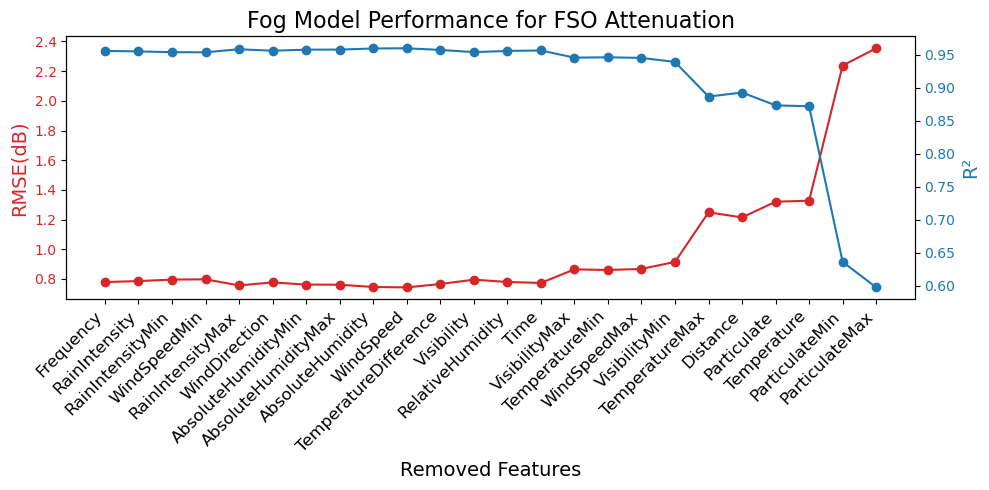

In [16]:
# Fog
ordered_features_fog = feature_selection_for_weather(X_train_fog.drop(columns=['SYNOPCode']), y_train_fog, 4, 'Fog')

In [17]:
fog_features = ordered_features_fog[-11:] #8
print(fog_features)

['Time', 'VisibilityMax', 'TemperatureMin', 'WindSpeedMax', 'VisibilityMin', 'TemperatureMax', 'Distance', 'Particulate', 'Temperature', 'ParticulateMin', 'ParticulateMax']



Processing SYNOP Code: 5 (Drizzle)
Iteration 1: RMSE = 0.9903, R² = 0.9246
Remaining features: 24
Iteration 2: RMSE = 0.9866, R² = 0.9251
Removed feature: Frequency. Remaining features: 23
Iteration 3: RMSE = 0.9958, R² = 0.9237
Removed feature: RainIntensityMax. Remaining features: 22
Iteration 4: RMSE = 0.9706, R² = 0.9275
Removed feature: WindDirection. Remaining features: 21
Iteration 5: RMSE = 0.9695, R² = 0.9277
Removed feature: RainIntensity. Remaining features: 20
Iteration 6: RMSE = 0.9680, R² = 0.9279
Removed feature: WindSpeed. Remaining features: 19
Iteration 7: RMSE = 0.9660, R² = 0.9282
Removed feature: AbsoluteHumidityMax. Remaining features: 18
Iteration 8: RMSE = 0.9593, R² = 0.9292
Removed feature: AbsoluteHumidityMin. Remaining features: 17
Iteration 9: RMSE = 0.9479, R² = 0.9309
Removed feature: RainIntensityMin. Remaining features: 16
Iteration 10: RMSE = 0.9539, R² = 0.9300
Removed feature: WindSpeedMin. Remaining features: 15
Iteration 11: RMSE = 0.9627, R² = 0.

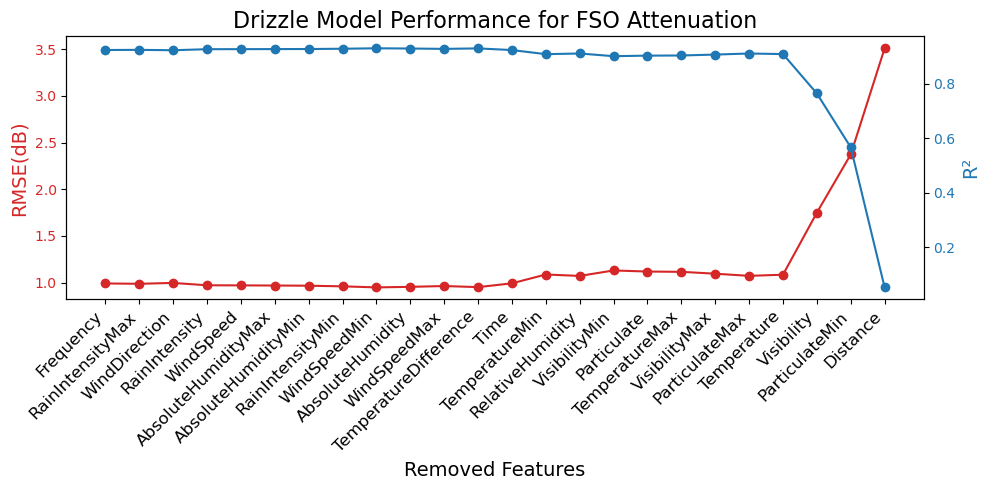

In [18]:
# Drizzle
ordered_features_drizzle = feature_selection_for_weather(X_train_drizzle.drop(columns=['SYNOPCode']), y_train_drizzle, 5, 'Drizzle')

In [19]:
drizzle_features = ordered_features_drizzle[-13:] #4
print(drizzle_features)

['TemperatureDifference', 'Time', 'TemperatureMin', 'RelativeHumidity', 'VisibilityMin', 'Particulate', 'TemperatureMax', 'VisibilityMax', 'ParticulateMax', 'Temperature', 'Visibility', 'ParticulateMin', 'Distance']



Processing SYNOP Code: 6 (Rain)
Iteration 1: RMSE = 0.9387, R² = 0.9527
Remaining features: 24
Iteration 2: RMSE = 0.9371, R² = 0.9528
Removed feature: Frequency. Remaining features: 23
Iteration 3: RMSE = 0.9287, R² = 0.9537
Removed feature: WindDirection. Remaining features: 22
Iteration 4: RMSE = 0.9268, R² = 0.9539
Removed feature: RainIntensityMax. Remaining features: 21
Iteration 5: RMSE = 0.9196, R² = 0.9546
Removed feature: AbsoluteHumidityMax. Remaining features: 20
Iteration 6: RMSE = 0.9259, R² = 0.9539
Removed feature: WindSpeedMin. Remaining features: 19
Iteration 7: RMSE = 0.9111, R² = 0.9554
Removed feature: AbsoluteHumidityMin. Remaining features: 18
Iteration 8: RMSE = 0.9017, R² = 0.9563
Removed feature: RainIntensityMin. Remaining features: 17
Iteration 9: RMSE = 0.9074, R² = 0.9558
Removed feature: WindSpeed. Remaining features: 16
Iteration 10: RMSE = 0.9221, R² = 0.9543
Removed feature: WindSpeedMax. Remaining features: 15
Iteration 11: RMSE = 0.9152, R² = 0.9550

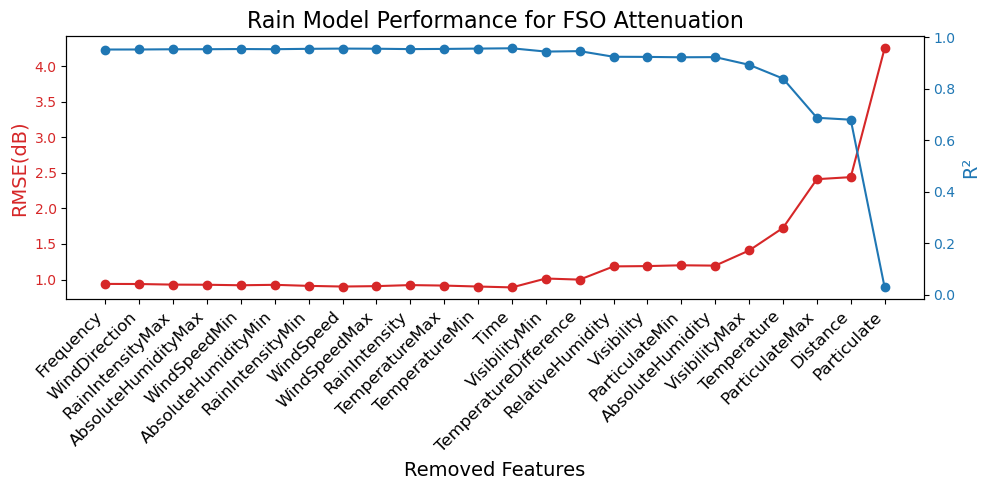

In [20]:
# Rain
ordered_features_rain = feature_selection_for_weather(X_train_rain.drop(columns=['SYNOPCode']), y_train_rain, 6, 'Rain')

In [21]:
rain_features = ordered_features_rain[-12:] # 10也行
print(rain_features)

['Time', 'VisibilityMin', 'TemperatureDifference', 'RelativeHumidity', 'Visibility', 'ParticulateMin', 'AbsoluteHumidity', 'VisibilityMax', 'Temperature', 'ParticulateMax', 'Distance', 'Particulate']



Processing SYNOP Code: 7 (Snow)
Iteration 1: RMSE = 1.2819, R² = 0.9427
Remaining features: 24
Iteration 2: RMSE = 1.2776, R² = 0.9431
Removed feature: Frequency. Remaining features: 23
Iteration 3: RMSE = 1.2924, R² = 0.9417
Removed feature: RainIntensity. Remaining features: 22
Iteration 4: RMSE = 1.2803, R² = 0.9428
Removed feature: WindDirection. Remaining features: 21
Iteration 5: RMSE = 1.2573, R² = 0.9449
Removed feature: RainIntensityMin. Remaining features: 20
Iteration 6: RMSE = 1.2806, R² = 0.9428
Removed feature: WindSpeed. Remaining features: 19
Iteration 7: RMSE = 1.2627, R² = 0.9444
Removed feature: Distance. Remaining features: 18
Iteration 8: RMSE = 1.2393, R² = 0.9464
Removed feature: RainIntensityMax. Remaining features: 17
Iteration 9: RMSE = 1.2379, R² = 0.9465
Removed feature: VisibilityMin. Remaining features: 16
Iteration 10: RMSE = 1.2642, R² = 0.9442
Removed feature: AbsoluteHumidityMax. Remaining features: 15
Iteration 11: RMSE = 1.2446, R² = 0.9460
Removed 

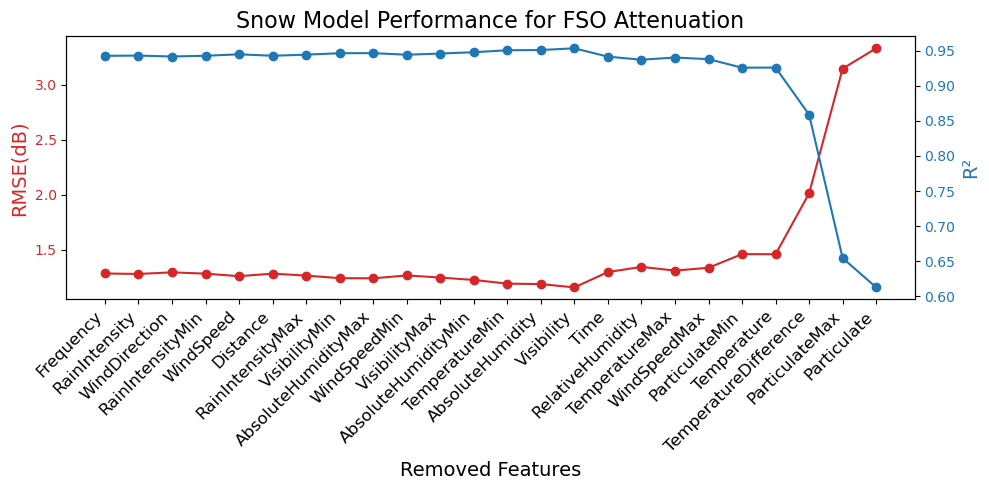

In [22]:
# Snow
ordered_features_snow = feature_selection_for_weather(X_train_snow.drop(columns=['SYNOPCode']), y_train_snow, 7, 'Snow')

In [23]:
snow_features = ordered_features_snow[-10:] # 7，9
print(snow_features)

['Visibility', 'Time', 'RelativeHumidity', 'TemperatureMax', 'WindSpeedMax', 'ParticulateMin', 'Temperature', 'TemperatureDifference', 'ParticulateMax', 'Particulate']



Processing SYNOP Code: 8 (Showers)
Iteration 1: RMSE = 1.0037, R² = 0.9323
Remaining features: 24
Iteration 2: RMSE = 1.0071, R² = 0.9319
Removed feature: Frequency. Remaining features: 23
Iteration 3: RMSE = 0.9851, R² = 0.9348
Removed feature: RainIntensity. Remaining features: 22
Iteration 4: RMSE = 0.9907, R² = 0.9341
Removed feature: WindSpeedMin. Remaining features: 21
Iteration 5: RMSE = 0.9789, R² = 0.9356
Removed feature: WindDirection. Remaining features: 20
Iteration 6: RMSE = 0.9767, R² = 0.9359
Removed feature: WindSpeed. Remaining features: 19
Iteration 7: RMSE = 0.9809, R² = 0.9354
Removed feature: RainIntensityMin. Remaining features: 18
Iteration 8: RMSE = 0.9764, R² = 0.9360
Removed feature: TemperatureMax. Remaining features: 17
Iteration 9: RMSE = 0.9971, R² = 0.9332
Removed feature: TemperatureDifference. Remaining features: 16
Iteration 10: RMSE = 0.9980, R² = 0.9331
Removed feature: ParticulateMax. Remaining features: 15
Iteration 11: RMSE = 0.9946, R² = 0.9335


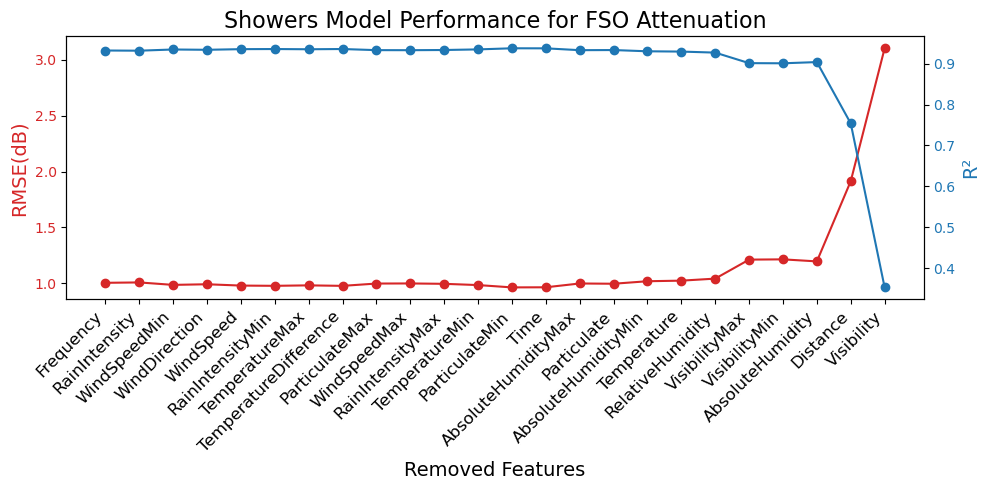

In [24]:
# Showers
ordered_features_showers = feature_selection_for_weather(X_train_showers.drop(columns=['SYNOPCode']), y_train_showers, 8, 'Showers')

In [25]:
showers_features = ordered_features_showers[-6:] # -9
print(showers_features)

['RelativeHumidity', 'VisibilityMax', 'VisibilityMin', 'AbsoluteHumidity', 'Distance', 'Visibility']


### 3.2 Hyperparameter optimisation and Model training with important features for specific models

In [26]:
def train_rf_model(X_train, y_train, feature_list, condition):
    
    # Select features based on the given feature list
    X_train_selected = X_train[feature_list]

    # Define the Random Forest model
    rf_model = RandomForestRegressor(oob_score=True, random_state=22)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

    # Perform hyperparameter tuning
    grid_search.fit(X_train_selected, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Make predictions on the training set using the best model
    y_train_pred = best_model.predict(X_train_selected)

    # Calculate RMSE and R² for the training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    # Print RMSE and R² for the training set
    print(f"Training Performance for {condition}: RMSE = {train_rmse:.4f}, R² = {train_r2:.4f}")

    # Perform cross-validation using the best model
    cv_rmse = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_r2 = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='r2')

    # Calculate average RMSE and R²
    avg_rmse = -cv_rmse.mean()  # Convert negative score to normal RMSE
    avg_r2 = cv_r2.mean()

    # Print cross-validation performance metrics
    print(f"Model Performance for {condition} (Cross-Validation): RMSE = {avg_rmse:.4f}, R² = {avg_r2:.4f}")

    # Retrain the model on the entire training set with the best parameters
    final_model = grid_search.best_estimator_
    final_model.fit(X_train_selected, y_train)

    # Save the best model in the dictionary
    models[condition] = final_model

    # Return the best hyperparameters
    print(f"Best parameters for {condition}: {grid_search.best_params_}")

# Define the models dictionary
models = {}

In [27]:
# Clear
train_rf_model(X_train_clear, y_train_clear, clear_features, 'Clear')

# Dust Storm
train_rf_model(X_train_dust_storm, y_train_dust_storm, dust_storm_features, 'Dust Storm')

# Fog
train_rf_model(X_train_fog, y_train_fog, fog_features, 'Fog')

# Drizzle
train_rf_model(X_train_drizzle, y_train_drizzle, drizzle_features, 'Drizzle')

# Rain
train_rf_model(X_train_rain, y_train_rain, rain_features, 'Rain')

# Snow
train_rf_model(X_train_snow, y_train_snow, snow_features, 'Snow')

# Showers
train_rf_model(X_train_showers, y_train_showers, showers_features, 'Showers')

Training Performance for Clear: RMSE = 0.3353, R² = 0.9910
Model Performance for Clear (Cross-Validation): RMSE = 0.9460, R² = 0.9282
Best parameters for Clear: {'max_depth': None, 'n_estimators': 200}
Training Performance for Dust Storm: RMSE = 0.7469, R² = 0.9917
Model Performance for Dust Storm (Cross-Validation): RMSE = 2.3416, R² = 0.8983
Best parameters for Dust Storm: {'max_depth': 10, 'n_estimators': 200}
Training Performance for Fog: RMSE = 0.2858, R² = 0.9941
Model Performance for Fog (Cross-Validation): RMSE = 0.7719, R² = 0.9530
Best parameters for Fog: {'max_depth': None, 'n_estimators': 100}
Training Performance for Drizzle: RMSE = 0.3370, R² = 0.9913
Model Performance for Drizzle (Cross-Validation): RMSE = 0.9724, R² = 0.9267
Best parameters for Drizzle: {'max_depth': None, 'n_estimators': 200}
Training Performance for Rain: RMSE = 0.3205, R² = 0.9945
Model Performance for Rain (Cross-Validation): RMSE = 0.9225, R² = 0.9542
Best parameters for Rain: {'max_depth': None, '

### 3.3 Combine and evaluate 7 different weather condition models using the test set

In [28]:
# Mapping condition codes to weather conditions
condition_map = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

def specific_random_forest_model(test_data, models):
    specific_val_predictions = []
    
    # Initialize a dictionary to store predictions for each weather condition
    condition_predictions = {condition: [] for condition in condition_map.values()}

    for index, row in test_data.iterrows():
        condition_code = row['SYNOPCode']
        condition = condition_map.get(condition_code, None)  # Get the weather condition
        
        if condition == 'Clear':
            prediction = models['Clear'].predict(pd.DataFrame([row[clear_features]], columns=clear_features))[0]
        elif condition == 'Dust Storm':
            prediction = models['Dust Storm'].predict(pd.DataFrame([row[dust_storm_features]], columns=dust_storm_features))[0]
        elif condition == 'Fog':
            prediction = models['Fog'].predict(pd.DataFrame([row[fog_features]], columns=fog_features))[0]
        elif condition == 'Drizzle':
            prediction = models['Drizzle'].predict(pd.DataFrame([row[drizzle_features]], columns=drizzle_features))[0]
        elif condition == 'Rain':
            prediction = models['Rain'].predict(pd.DataFrame([row[rain_features]], columns=rain_features))[0]
        elif condition == 'Snow':
            prediction = models['Snow'].predict(pd.DataFrame([row[snow_features]], columns=snow_features))[0]
        elif condition == 'Showers':
            prediction = models['Showers'].predict(pd.DataFrame([row[showers_features]], columns=showers_features))[0]
        else:
            prediction = None  # Return None if the condition doesn't match

        specific_val_predictions.append(prediction)
        
        # Add the prediction to the corresponding weather condition
        if condition is not None:
            condition_predictions[condition].append(prediction)

    return specific_val_predictions, condition_predictions

In [29]:
predictions, condition_predictions = specific_random_forest_model(X_test, models)

# Calculate overall RMSE and R²
speci_rmse = np.sqrt(mean_squared_error(y_test, predictions))
speci_r2 = r2_score(y_test, predictions)

# Initialize a dictionary to store RMSE and R² for each condition
spec_condition_results = {}

# Create a dictionary to store actual values
actual_values = {condition: [] for condition in condition_predictions.keys()}

# Classify the actual values of y_val into their corresponding weather conditions
for index, row in X_test.iterrows():
    condition_code = row['SYNOPCode']
    condition = condition_map.get(condition_code, None)
    
    if condition in actual_values:
        actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])

# Calculate RMSE and R² for each weather condition
for condition in condition_predictions.keys():
    if condition_predictions[condition]:  # Ensure there are predictions
        rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
        r2 = r2_score(actual_values[condition], condition_predictions[condition])
        
        # Store RMSE and R² in the dictionary
        spec_condition_results[condition] = {
            'RMSE': rmse,
            'R²': r2
        }

        # Print the results
        print(f'Condition {condition}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

# Print overall results
print(f'Overall RMSE of specific RF model: {speci_rmse:.4f}')
print(f'Overall R² of specific RF model: {speci_r2:.4f}')

Condition Clear: RMSE = 0.8793, R² = 0.9366
Condition Dust Storm: RMSE = 1.6137, R² = 0.9607
Condition Fog: RMSE = 0.6585, R² = 0.9778
Condition Drizzle: RMSE = 0.8884, R² = 0.9361
Condition Rain: RMSE = 0.7972, R² = 0.9657
Condition Snow: RMSE = 0.8071, R² = 0.9752
Condition Showers: RMSE = 1.2457, R² = 0.9129
Overall RMSE of specific RF model: 0.8676
Overall R² of specific RF model: 0.9505


In [30]:
# Use set to calculate the union
union_set = set(clear_features).union(dust_storm_features, fog_features, drizzle_features, rain_features, snow_features, showers_features)

# Convert the union back to a list
union_list = list(union_set)

# Output the results
print("Number of selected features:", len(union_list))
print(union_list)

Number of selected features: 15
['TemperatureMax', 'Distance', 'Time', 'ParticulateMin', 'RelativeHumidity', 'TemperatureDifference', 'TemperatureMin', 'ParticulateMax', 'AbsoluteHumidity', 'Visibility', 'VisibilityMin', 'WindSpeedMax', 'Particulate', 'VisibilityMax', 'Temperature']


## 4. Model Comparison

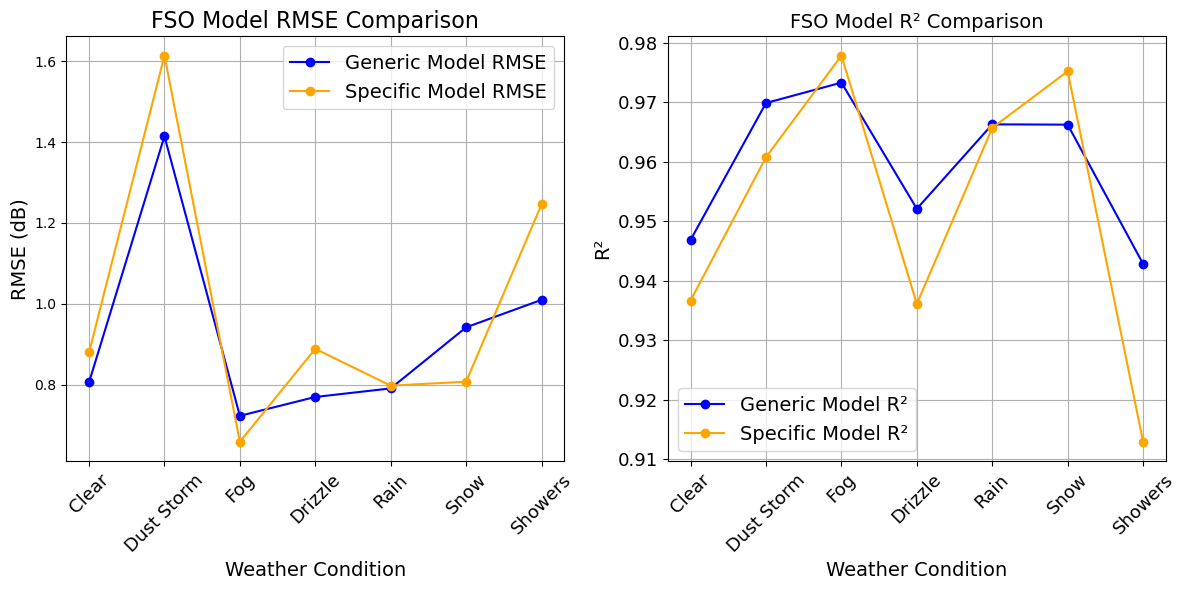

In [31]:
# Extract weather conditions
conditions = list(gene_condition_results.keys())

# Extract RMSE and R² values
gene_rmse = [gene_condition_results[condition]['RMSE'] for condition in conditions]
gene_r2 = [gene_condition_results[condition]['R²'] for condition in conditions]

spec_rmse = [spec_condition_results[condition]['RMSE'] for condition in conditions]
spec_r2 = [spec_condition_results[condition]['R²'] for condition in conditions]

# Set up the canvas
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(conditions, gene_rmse, marker='o', color='blue', label='Generic Model RMSE')
plt.plot(conditions, spec_rmse, marker='o', color='orange', label='Specific Model RMSE')
plt.title('FSO Model RMSE Comparison', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('RMSE (dB)', fontsize=14)
plt.xticks(rotation=45, fontsize=13)
plt.legend(fontsize=14)
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(conditions, gene_r2, marker='o', color='blue', label='Generic Model R²')
plt.plot(conditions, spec_r2, marker='o', color='orange', label='Specific Model R²')
plt.title('FSO Model R² Comparison', fontsize=14)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13) 
plt.legend(fontsize=14)
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

From the figures, we can find the generic model performs better than the specific model in all weather conditions except for fog and snow, as its RMSE is lower and r2 is higher. This result aligns with the overall metrics, suggesting that the generic model is the best model for predicting FSO attenuation.

In [32]:
# Compare RMSE and R² to select the best model
if rmse_test < speci_rmse and r2_test > speci_r2:
    best_model = "Generic RF Model"
else:
    best_model = "Specific Model"

# Output the best model's information
print(f'specific model: RMSE = {speci_rmse:.4f}, R² = {speci_r2:.4f}')
print(f'generic model: RMSE = {rmse_test:.4f}, R² = {r2_test:.4f}')
print(f"The best model is: {best_model}")

specific model: RMSE = 0.8676, R² = 0.9505
generic model: RMSE = 0.8051, R² = 0.9573
The best model is: Generic RF Model


In [33]:
X_test['SYNOPCode'].value_counts()

0    17089
6     7505
5     1982
8      515
4      140
7      126
3       57
Name: SYNOPCode, dtype: int64

In [34]:
# Results of Generic and Specific models
gene_condition_results
spec_condition_results 

# Initialize a DataFrame to store the results
weather_conditions = ['Clear', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']
columns = ['RMSE Difference', 'RMSE Improvement (%)', 'R² Difference', 'R² Improvement (%)']

results_df = pd.DataFrame(index=weather_conditions, columns=columns)

# Calculate RMSE and R² differences and improvement percentages
for condition in weather_conditions:
    # RMSE and R² for Generic and Specific models
    gene_rmse = gene_condition_results[condition]['RMSE']
    spec_rmse = spec_condition_results[condition]['RMSE']
    
    gene_r2 = gene_condition_results[condition]['R²']
    spec_r2 = spec_condition_results[condition]['R²']
    
    # Differences
    rmse_diff = gene_rmse - spec_rmse
    r2_diff = gene_r2 - spec_r2  
    
    # Improvement percentages
    rmse_improvement_pct = - (rmse_diff / spec_rmse) * 100
    r2_improvement_pct = (r2_diff / spec_r2) * 100
    
    # Fill the DataFrame
    results_df.loc[condition, 'RMSE Difference'] = round(rmse_diff, 3)
    results_df.loc[condition, 'RMSE Improvement (%)'] = round(rmse_improvement_pct, 3)
    
    results_df.loc[condition, 'R² Difference'] = round(r2_diff, 3)
    results_df.loc[condition, 'R² Improvement (%)'] = round(r2_improvement_pct, 3)

# Set display options to avoid automatic line breaks
pd.set_option('display.expand_frame_repr', False)  # Force the table to display on one line

# Set font size
plt.rcParams['font.size'] = 14  # Set font size to 14

# Add a title explaining the differences
title = """
Table: FSO: Amount of Improvement Provided by the Generic Model Over the Specific Model 
- RMSE Difference: The difference between the Specific Model RMSE and Generic Model RMSE.
- RMSE Improvement (%): The percentage improvement in RMSE of the Generic Model over the Specific Model (positive values indicate improvement).
- R² Difference: The difference between the Generic Model R² and the Specific Model R².
- R² Improvement (%): The percentage improvement in R² of the Generic Model over the Specific Model (positive values indicate improvement).
"""

# Print title and table
print(title)
print(results_df)


Table: FSO: Amount of Improvement Provided by the Generic Model Over the Specific Model 
- RMSE Difference: The difference between the Specific Model RMSE and Generic Model RMSE.
- RMSE Improvement (%): The percentage improvement in RMSE of the Generic Model over the Specific Model (positive values indicate improvement).
- R² Difference: The difference between the Generic Model R² and the Specific Model R².
- R² Improvement (%): The percentage improvement in R² of the Generic Model over the Specific Model (positive values indicate improvement).

           RMSE Difference RMSE Improvement (%) R² Difference R² Improvement (%)
Clear               -0.074                8.397          0.01              1.088
Dust Storm          -0.199               12.355         0.009              0.947
Fog                  0.064               -9.735        -0.005             -0.464
Drizzle             -0.119                13.41         0.016              1.709
Rain                -0.007                

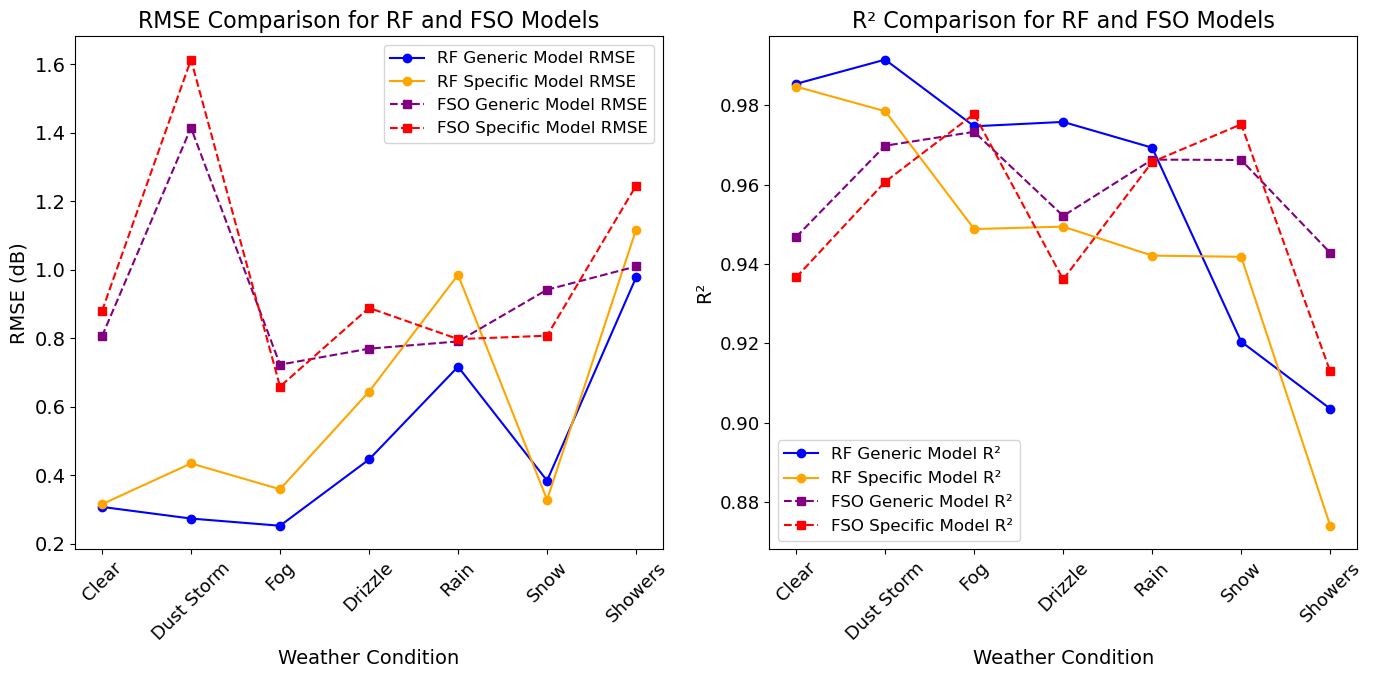

In [35]:
# Set weather conditions
conditions = ['Clear', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

# Extract RMSE values for each model
rf_gene_rmse = [0.3069, 0.2729, 0.2519, 0.4455, 0.7166, 0.3837, 0.9774]
rf_spec_rmse = [0.3148, 0.4340, 0.3586, 0.6437, 0.9849, 0.3279, 1.1170]
fso_gene_rmse = [0.8054, 1.4144, 0.7226, 0.7692, 0.7904, 0.9415, 1.0095]
fso_spec_rmse = [0.8793, 1.6137, 0.6585, 0.8884, 0.7972, 0.8071, 1.2457]

# Extract R² values for each model
rf_gene_r2 = [0.9854, 0.9915, 0.9747, 0.9758, 0.9693, 0.9204, 0.9035]
rf_spec_r2 = [0.9847, 0.9785, 0.9488, 0.9494, 0.9421, 0.9418, 0.8740]
fso_gene_r2 = [0.9468, 0.9698, 0.9733, 0.9521, 0.9663, 0.9662, 0.9428]
fso_spec_r2 = [0.9366, 0.9607, 0.9778, 0.9361, 0.9657, 0.9752, 0.9129]

# Set up the canvas
plt.figure(figsize=(14, 7))

# Plot the RMSE graph
plt.subplot(1, 2, 1)
plt.plot(conditions, rf_gene_rmse, marker='o', color='blue', label='RF Generic Model RMSE')
plt.plot(conditions, rf_spec_rmse, marker='o', color='orange', label='RF Specific Model RMSE')
plt.plot(conditions, fso_gene_rmse, marker='s', color='purple', linestyle='--', label='FSO Generic Model RMSE')
plt.plot(conditions, fso_spec_rmse, marker='s', color='red', linestyle='--', label='FSO Specific Model RMSE')
plt.title('RMSE Comparison for RF and FSO Models', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('RMSE (dB)', fontsize=14)
plt.xticks(rotation=45, fontsize=13)
plt.legend(fontsize=12)

# Remove grid lines
plt.grid(False)

# Plot the R² graph
plt.subplot(1, 2, 2)
plt.plot(conditions, rf_gene_r2, marker='o', color='blue', label='RF Generic Model R²')
plt.plot(conditions, rf_spec_r2, marker='o', color='orange', label='RF Specific Model R²')
plt.plot(conditions, fso_gene_r2, marker='s', color='purple', linestyle='--', label='FSO Generic Model R²')
plt.plot(conditions, fso_spec_r2, marker='s', color='red', linestyle='--', label='FSO Specific Model R²')
plt.title('R² Comparison for RF and FSO Models', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

# Remove grid lines
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()